## Задание 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

from tpot import TPOTClassifier

from fedot.api.main import Fedot

import mlflow
from mlflow.models import infer_signature

'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [2]:
df = pd.read_csv('data/task2.csv')
df.head()

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77


### Визуализируем данные с помощью boxplot

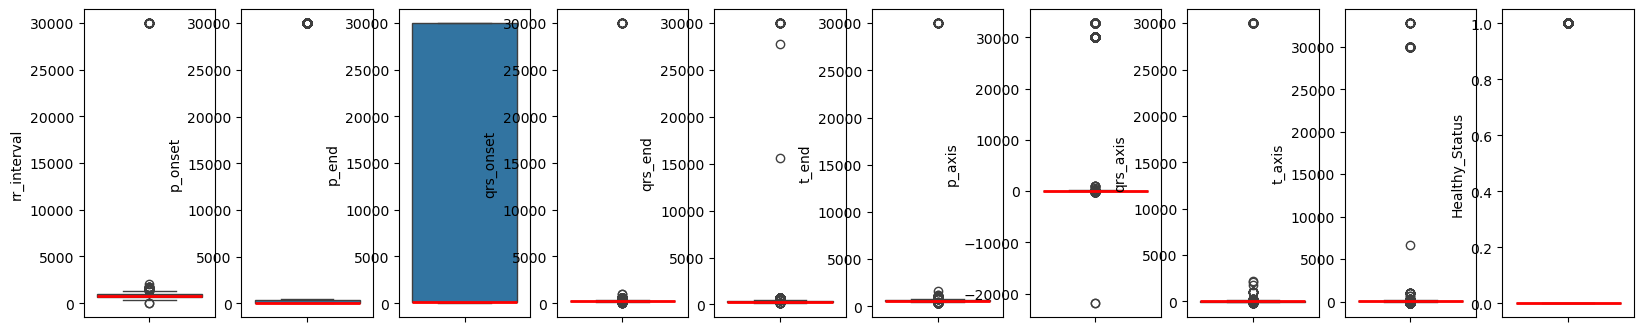

In [3]:
# Убираем лишние столбцы
columns_to_filter = [
    'rr_interval','p_onset','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status'
]
full_df_filtered = df[columns_to_filter]

n = full_df_filtered.shape[1]
fig, ax = plt.subplots(1, n, figsize=(n*2, 4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    sns.boxplot(y=full_df_filtered.iloc[:, i], data=full_df_filtered, medianprops={"color": "r", "linewidth": 2})

Как видно, в данных присутствует много выбросов, в результате графики становятся неинформативаными. Поэтому исходные данные перед визуализацией необходимо предобработать

### Предобрабатываем данные

In [4]:
# Убираем выбросы
columns_to_filter = [
    'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis'
]
full_df_filtered = df[(df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[
    (full_df_filtered['p_onset'] < full_df_filtered['p_end']) & 
    (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])
]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = (
    full_df_filtered['report_0'].
    str.replace(r'\bnan\b', '', regex=True).
    str.replace(r'\s+', ' ', regex=True).str.strip()
)
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Исправляем имена столбцов
full_df_filtered = full_df_filtered\
    .rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})\
    .drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered =\
    full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены и обучаем модель
words = [text.split() for text in full_df_filtered['report']]
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    
    # Если слово есть в модели, то возвращаем усреднённый вектор.
    # В противном случае возвращаем нулевой вектор
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())
full_df_filtered.head()

2025-04-21 07:38:55,114 - collecting all words and their counts
2025-04-21 07:38:55,118 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-04-21 07:38:55,183 - collected 514 word types from a corpus of 91190 raw words and 7046 sentences
2025-04-21 07:38:55,184 - Creating a fresh vocabulary
2025-04-21 07:38:55,190 - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 330 unique words (64.20% of original 514, drops 184)', 'datetime': '2025-04-21T07:38:55.190389', 'gensim': '4.3.0', 'python': '3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]', 'platform': 'Linux-6.12.5-linuxkit-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
2025-04-21 07:38:55,192 - Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 90834 word corpus (99.61% of original 91190, drops 356)', 'datetime': '2025-04-21T07:38:55.192373', 'gensim': '4.3.0', 'python': '3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]', 'platform': 'Linux-6.12.5-linuxkit-x86_64-with-glibc2.31', 'ev

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.031776,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.031776,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,-0.004869,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.004056,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.004056,952,40,146,198,282,598,24,80,20,1


In [5]:
table_data = full_df_filtered[
    ['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']
]
table_data.head()

,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,0.031776,659,128,170,258,518,81,77,79,0
1,0.031776,722,124,162,246,504,77,75,70,0
2,-0.004869,600,130,162,244,474,79,72,77,1
3,0.004056,659,146,180,254,538,79,66,69,1
6,0.004056,952,146,198,282,598,24,80,20,1


### Визиализируем данные с помощью boxplot

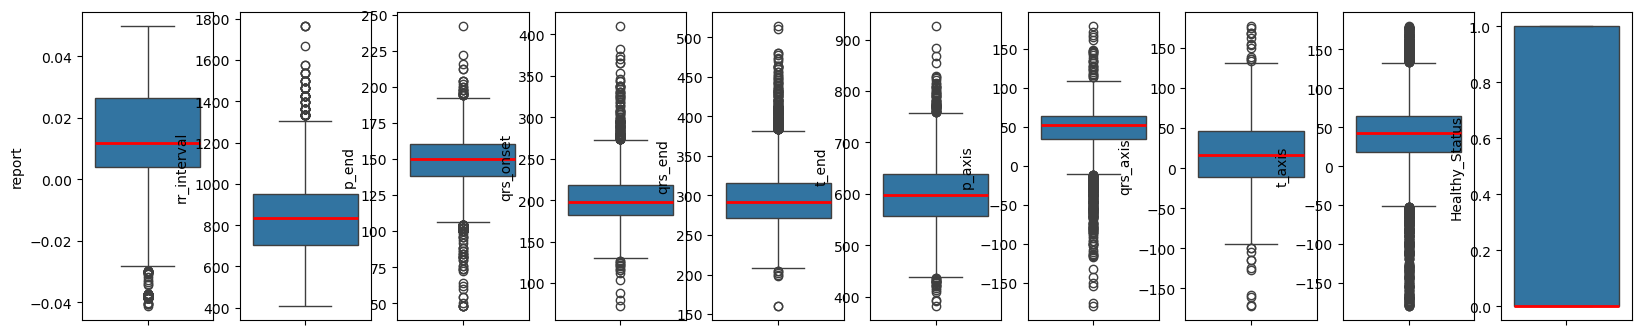

In [6]:
n = table_data.shape[1]
fig, ax = plt.subplots(1, n, figsize=(n*2, 4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    sns.boxplot(y=table_data.iloc[:,i], data=table_data, medianprops={"color": "r", "linewidth": 2})

Как видно, после предобработки данных графики стали более информатируемыми и понятными

### Визуализируем данные с помощью heatmap

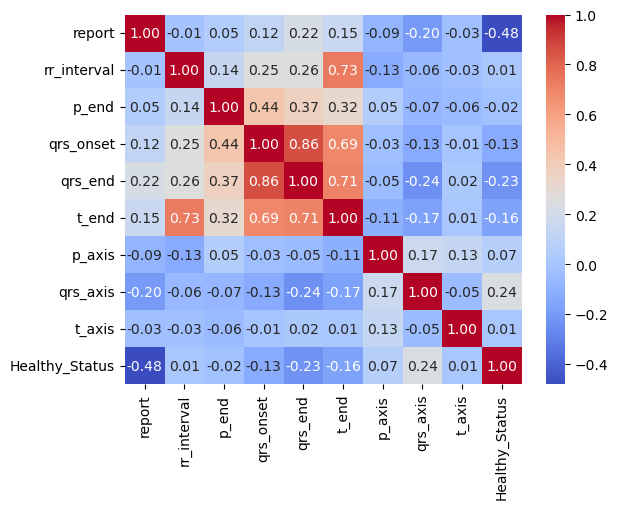

In [7]:
sns.heatmap(table_data.corr(), annot=True, fmt='0.2f', cmap='coolwarm')
plt.show()

### Визуализируем данные с помощью pairplot

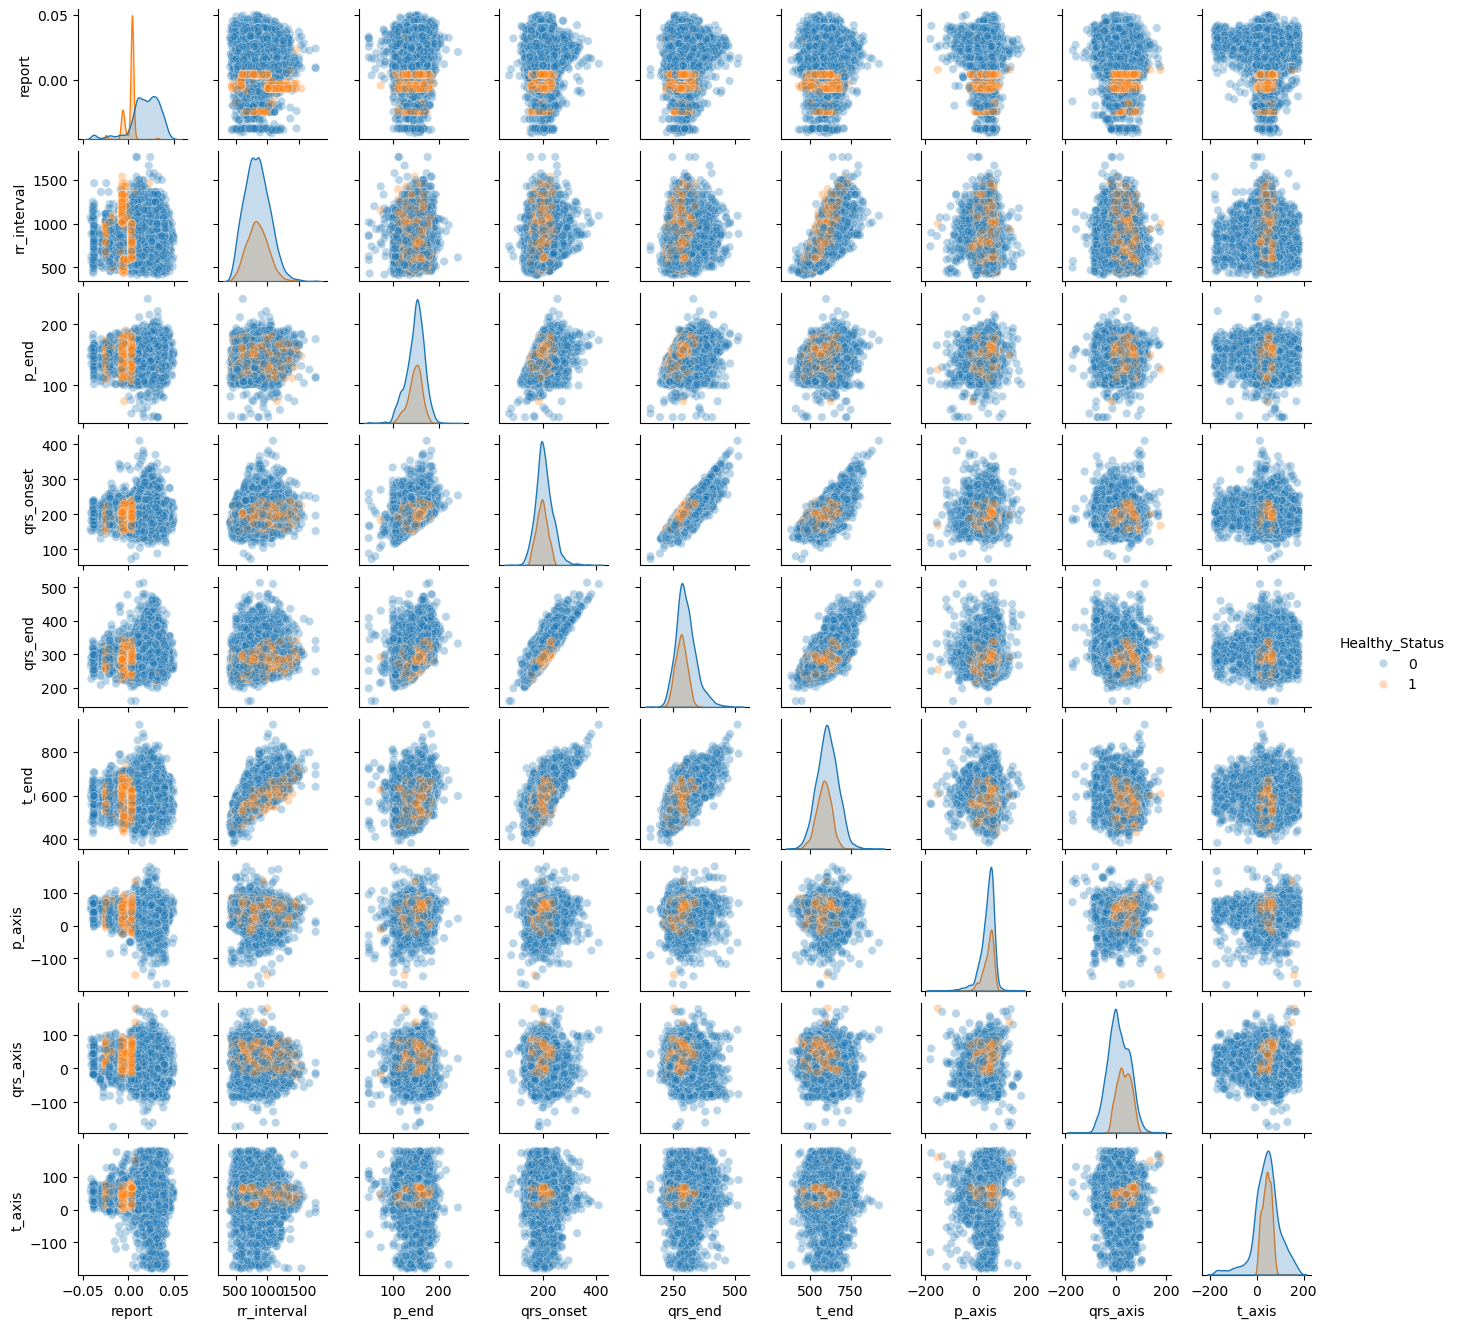

In [8]:
sns.pairplot(table_data, hue='Healthy_Status', height=1.5, plot_kws=dict(alpha=0.3))

### Обработка данных с помощью PCA и t-SNE

In [9]:
table_data_pca = table_data.drop('Healthy_Status', axis = 1)
scaled_data = StandardScaler().fit_transform(table_data_pca)

pca = PCA(n_components=2).fit(scaled_data)
x_pca = pca.transform(scaled_data)

(table_data.shape, x_pca.shape)

((7046, 10), (7046, 2))

Text(0, 0.5, 'Second Principal Component')

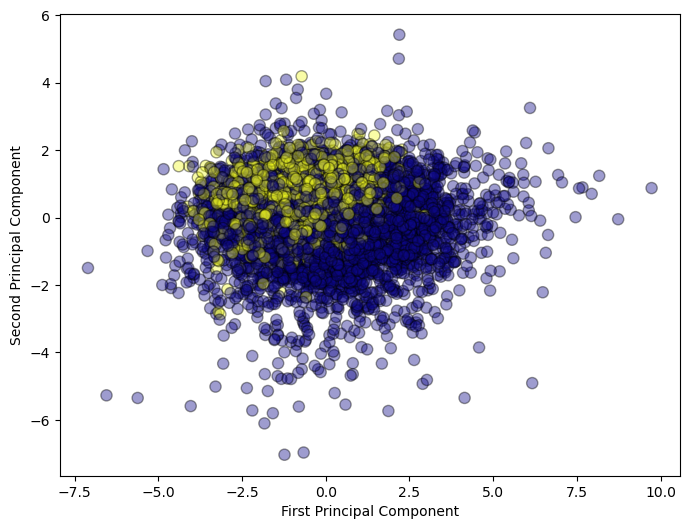

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(
    x_pca[:,0], x_pca[:,1],
    c=full_df_filtered['Healthy_Status'],
    cmap='plasma',
    alpha=0.4,
    edgecolors='black',
    s=65
)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

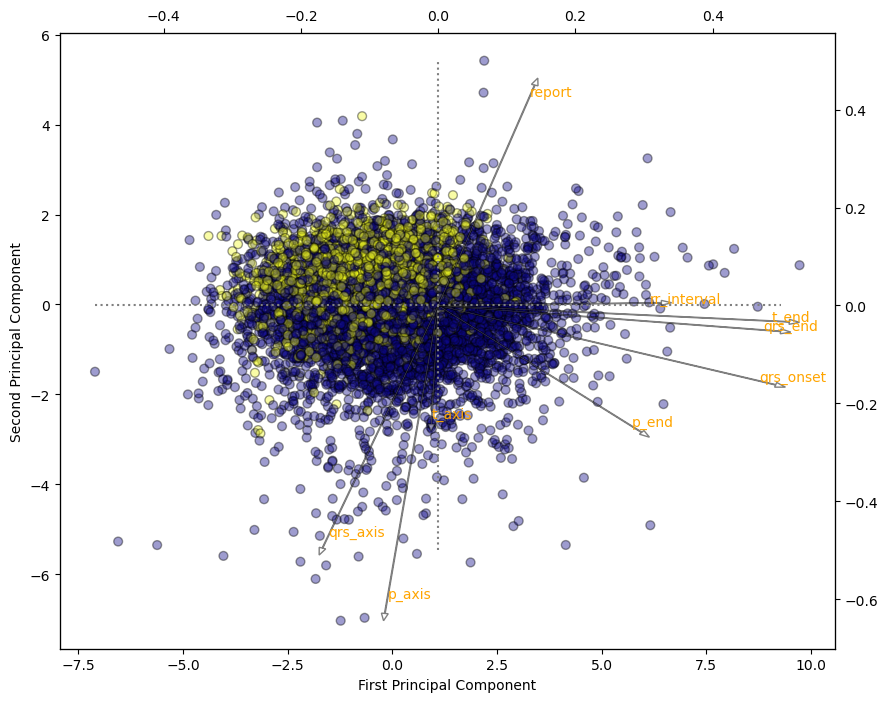

In [11]:
plt.figure(figsize=(10,8))
plt.scatter(
    x_pca[:,0], x_pca[:,1],
    c=full_df_filtered['Healthy_Status'],
    cmap='plasma',
    alpha=0.4,
    edgecolors='black',
    s=40
)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

ax2 = plt.twinx().twiny()
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

offset = 0.95
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns=['PCA1','PCA2'])
for a, i in enumerate(components.index):
    ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
    ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

Text(0, 0.5, 'Second Principal Component')

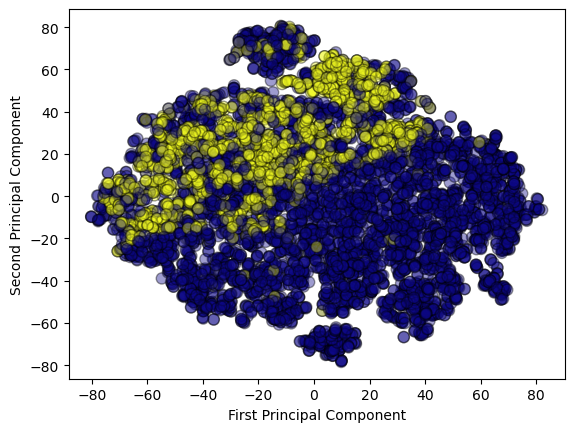

In [12]:
tsne = TSNE(random_state=0)
scaled_data_tsne = tsne.fit_transform(scaled_data)

plt.scatter(
    scaled_data_tsne[:,0], 
    scaled_data_tsne[:,1], 
    c=full_df_filtered['Healthy_Status'], 
    cmap='plasma', 
    alpha=0.4, 
    edgecolors='black', 
    s=65
)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Time code evaluation for perplexity=1 in 36 sec
Time code evaluation for perplexity=5 in 43 sec
Time code evaluation for perplexity=10 in 52 sec
Time code evaluation for perplexity=15 in 8.4e+02 sec
Time code evaluation for perplexity=20 in 9.6e+02 sec
Time code evaluation for perplexity=30 in 63 sec


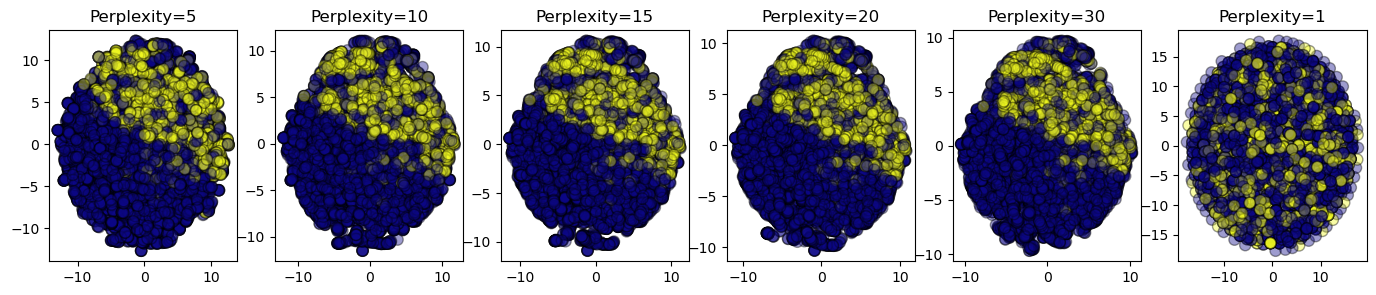

In [13]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30]

fig, subplots = plt.subplots(1, len(perplexities), figsize=(17, 3))
for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity, max_iter=300)
    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print('Time code evaluation for perplexity=%d in %.2g sec' % (perplexity, t1 - t0))
    ax.set_title('Perplexity=%d' % perplexity)
    ax.scatter(
        scaled_data_tsne[:,0], 
        scaled_data_tsne[:,1],
        c=full_df_filtered['Healthy_Status'],
        cmap='plasma',
        alpha=0.4,
        edgecolors='black',
        s=65
    )
    ax.axis('tight')

Как видно, методы PCA и TSNE демонстрируют разделение классов. Анализ графиков показывает, что на начальных значениях perplexity резльутаты примерно одинаковые

### Примененяем AutoML решения

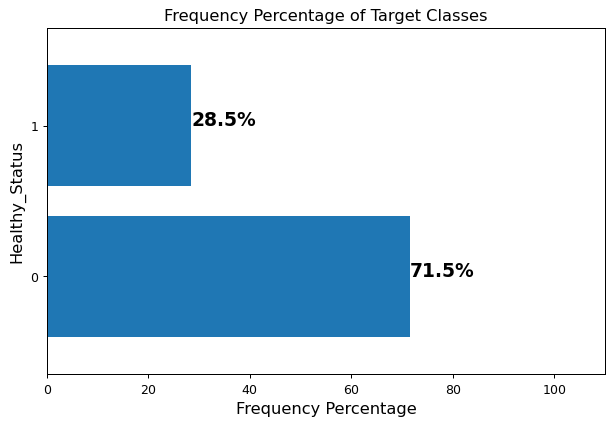

In [14]:
clf_index = 9
plt.figure(figsize=(35,20), dpi=90)
table_data[
    table_data.columns[clf_index]
].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

labels = table_data[
    table_data.columns[clf_index]
].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [15]:
smote = SMOTE(random_state=0)
X_initial = table_data.drop('Healthy_Status', axis=1)
y_initial = table_data['Healthy_Status']

# Применяем метод SMOTE, чтобы избавиться от дисбаланса классов
X, y = smote.fit_resample(X_initial, y_initial)
df = pd.DataFrame(X, columns=X_initial.columns)

df['Healthy_Status'] = y
df['Healthy_Status'].value_counts()

Healthy_Status
0    5039
1    5039
Name: count, dtype: int64

In [16]:
X = df.drop(df.columns[[clf_index]], axis=1).iloc[:,:]
y = pd.Series(LabelEncoder().fit_transform(df.iloc[:, clf_index]))

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values,
    test_size=0.3, random_state=0, stratify=y.values
)

In [17]:
# Берем за базовую отметку результаты модели наивного гауссовского байесовского алгоритма
сlassifier = GaussianNB()
сlassifier.fit(X_train, y_train)

GaussianNB()

In [18]:
y_train__pred = сlassifier.predict(X_train)
y_test__pred = сlassifier.predict(X_test)

In [19]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__pred)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__pred)}'
)

('Accuracy train data 0.8641905301956336',
 'Accuracy test data 0.8677248677248677')

              precision    recall  f1-score   support

        True       0.94      0.79      0.86      1512
       False       0.82      0.95      0.88      1512

    accuracy                           0.87      3024
   macro avg       0.88      0.87      0.87      3024
weighted avg       0.88      0.87      0.87      3024



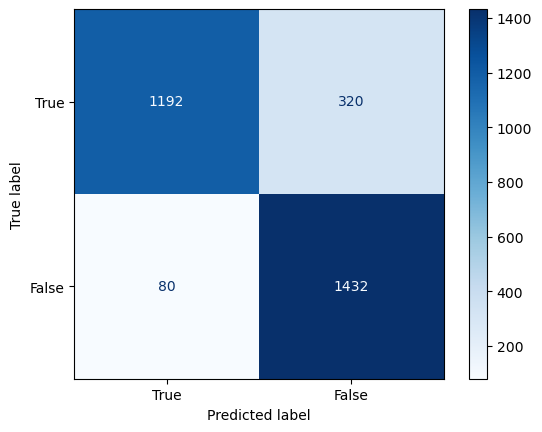

In [20]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__pred, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__pred, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [21]:
autoML_df = df[
    ['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']
]

train_data, test_data = train_test_split(
    autoML_df,
    test_size=0.2, stratify=autoML_df['Healthy_Status'], random_state=42
)
automl = TabularAutoML(
    task=Task('binary'),
    timeout=100,
    memory_limit=2,
    cpu_limit=1,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42}
)

In [22]:
predictions = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'}, verbose=0)
test_predictions = automl.predict(test_data).data

for i in range(len(test_predictions)):
    if test_predictions[i] > 0.5:
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0

predictions_data = predictions.data
for i in range(len(predictions_data)):
    if predictions_data[i] > 0.5:
        predictions_data[i] = 1
    else:
        predictions_data[i] = 0

In [23]:
(
    f'Accuracy train data {accuracy_score(train_data["Healthy_Status"], predictions_data)}',
    f'Accuracy test data {accuracy_score(test_data["Healthy_Status"], test_predictions)}'
)

('Accuracy train data 0.6329694864797817',
 'Accuracy test data 0.8958333333333334')

              precision    recall  f1-score   support

        True       0.90      0.88      0.89      1008
       False       0.89      0.91      0.90      1008

    accuracy                           0.90      2016
   macro avg       0.90      0.90      0.90      2016
weighted avg       0.90      0.90      0.90      2016



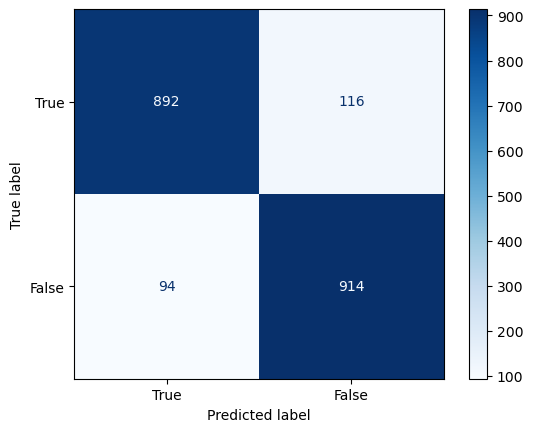

In [24]:
target_names = ['True', 'False']
labels_names = [0, 1]
print(
    classification_report(
        test_data['Healthy_Status'], test_predictions,
        labels=labels_names, target_names=target_names
    )
)

cm = confusion_matrix(test_data['Healthy_Status'], test_predictions, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [25]:
X = df.iloc[:, df.columns != 'Healthy_Status'].values
y = df.iloc[:, df.columns == 'Healthy_Status'].values.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)

In [26]:
tpot = TPOTClassifier(generations=1, population_size=1, random_state=42, max_time_mins=5)
tpot.fit(X_train, y_train)

Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.33s/it]


TPOTClassifier(max_time_mins=5, random_state=42,
               search_space=<tpot.search_spaces.pipelines.sequential.SequentialPipeline object at 0x2aacae3dfa10>)

In [27]:
y_train__predict = tpot.predict(X_train)
y_test__predict = tpot.predict(X_test)

In [28]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data 0.963141480011341',
 'Accuracy test data 0.9623015873015873')

              precision    recall  f1-score   support

        True       0.97      0.96      0.96      1511
       False       0.96      0.97      0.96      1513

    accuracy                           0.96      3024
   macro avg       0.96      0.96      0.96      3024
weighted avg       0.96      0.96      0.96      3024



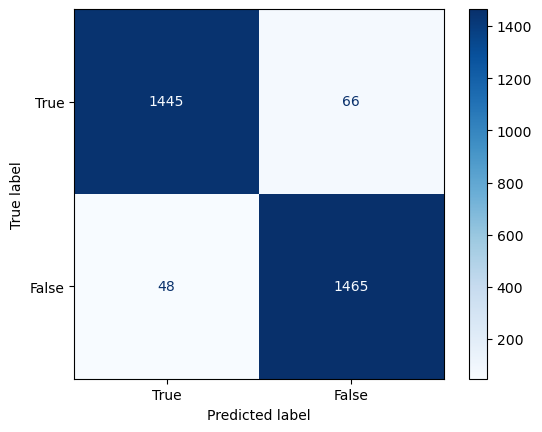

In [29]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__predict, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__predict, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

2025-04-21 08:30:48.459736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-04-21 08:31:34,801 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-21 08:32:06,695 - ApiComposer - Initial pipeline was fitted in 28.5 sec.
2025-04-21 08:32:06,700 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 142.4 sec.
2025-04-21 08:32:06,708 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2025-04-21 08:32:06,810 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].
2025-04-21 08:32:07,478 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 142.444495 sec.
2025-04-21 08:32:08,205 - ApiComposer - Hyperparameters tuning started with 3 min. timeout
2025-04-21 08:33:59,

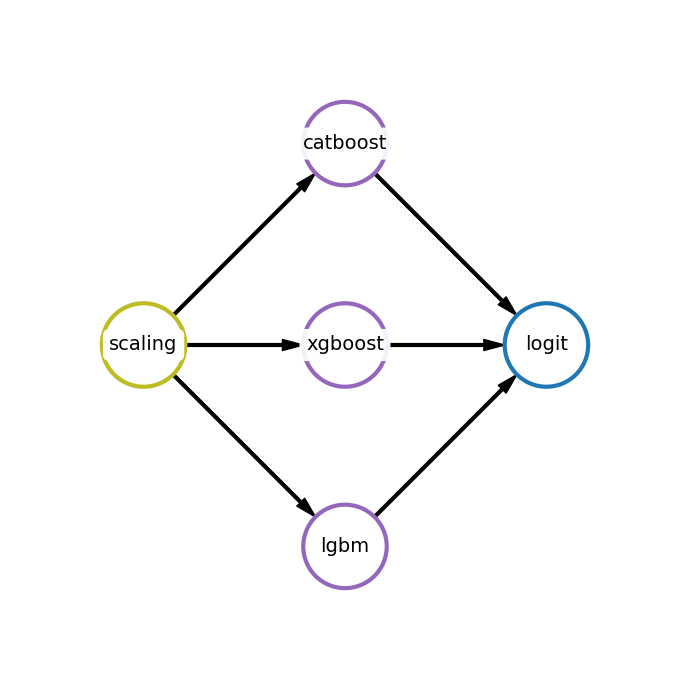

In [30]:
fedot_model = Fedot(problem='classification', timeout=3)
obtained_pipeline = fedot_model.fit(features=X_train, target=y_train)
obtained_pipeline.show()

In [31]:
y_train__predict = fedot_model.predict(X_train)
y_test__predict = fedot_model.predict(X_test)

In [32]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data 0.9956053303090445',
 'Accuracy test data 0.9791666666666666')

              precision    recall  f1-score   support

        True       0.98      0.98      0.98      1511
       False       0.98      0.98      0.98      1513

    accuracy                           0.98      3024
   macro avg       0.98      0.98      0.98      3024
weighted avg       0.98      0.98      0.98      3024



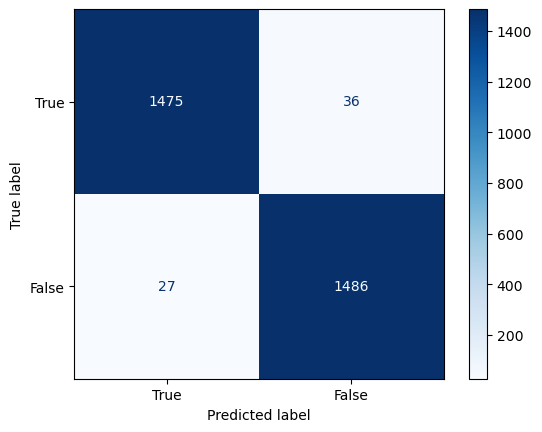

In [33]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__predict, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__predict, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [34]:
fedot_model.current_pipeline

{'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}

### Отображаем результаты в MLFlow

In [35]:
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')
mlflow.set_experiment('Task 2')

2025/04/21 08:35:14 INFO mlflow.tracking.fluent: Experiment with name 'Task 2' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/233056482772682901', creation_time=1745224514948, experiment_id='233056482772682901', last_update_time=1745224514948, lifecycle_stage='active', name='Task 2', tags={}>

In [36]:
with open('./models/task2_lama.pkl', 'wb') as f:
    pickle.dump(automl, f)

with mlflow.start_run(run_name='LAMA'):    
    mlflow.log_params(
        {
            'n_jobs': 4, 
            'cv': 3, 
            'random_state': 42
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(train_data["Healthy_Status"], predictions_data),
            'Accuracy test data': accuracy_score(test_data["Healthy_Status"], test_predictions)
        }
    )
    mlflow.log_artifact('./models/task2_lama.pkl')

    mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lama_model',
        signature=infer_signature(train_data, predictions_data),
        input_example=train_data
    )

🏃 View run LAMA at: http://127.0.0.1:8080/#/experiments/233056482772682901/runs/9c288b2dc8904f99bf07bf88d4b71333
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/233056482772682901


In [37]:
with open('./models/task2_tpot.pkl', 'wb') as f:
    pickle.dump(tpot.fitted_pipeline_, f)

with mlflow.start_run(run_name='TPOT'):
    y_train__predict = tpot.predict(X_train)
    y_test__predict = tpot.predict(X_test)
    
    mlflow.log_params(
        {
            'generations': 1,
            'population_size': 1,
            'random_state': 42
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./models/task2_tpot.pkl')

    mlflow.sklearn.log_model(
        sk_model=tpot.fitted_pipeline_,
        artifact_path='tpot_model',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train
    )

🏃 View run TPOT at: http://127.0.0.1:8080/#/experiments/233056482772682901/runs/28cfee7656f74caf8c2d044247ff1bb3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/233056482772682901


In [38]:
with open('./models/task2_fedot.pkl', 'wb') as f:
    pickle.dump(fedot_model, f)

with mlflow.start_run(run_name='FEDOT'):
    y_train__predict = fedot_model.predict(X_train)
    y_test__predict = fedot_model.predict(X_test)
    
    mlflow.log_params(
        {
            'problem':'classification',
            'timeout': 3
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./models/task2_fedot.pkl')
    
    mlflow.sklearn.log_model(
        sk_model=fedot_model,
        artifact_path='model_fedot',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train
    )

🏃 View run FEDOT at: http://127.0.0.1:8080/#/experiments/233056482772682901/runs/acb4a83b696b4b50945b0cf14d6f99d3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/233056482772682901
